In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
from typing import Tuple, List, Dict


def get_simulation_files() -> Tuple[Dict[str, List[str]], Dict[str, List[str]], Dict[str, List[str]]]:
    def add_file(dict : Dict, key: str, value: str) -> None:
        if key in dict:
            dict[key].append(value)
        else:
            dict[key] = [value]

    avg_degree, degree_distribution, giant_component = {}, {}, {}
    for file in os.listdir():
        if file.endswith(".txt"):
            [filename, _] = file.split("(")
            if filename.endswith("avg_degree"):
                add_file(avg_degree, filename, file)
            elif filename.endswith("degree_distribution"):
                add_file(degree_distribution, filename, file)
            elif filename.endswith("giant_component"):
                add_file(giant_component, filename, file)

    return avg_degree, degree_distribution, giant_component


def process_prefix(file_name: str) -> Tuple[int, int, float, float]:
    def get_fraction(fraction_str: str) -> float:
        [num, den] = fraction_str.split("d")
        return float(num) / float(den)

    file_info = file_name.split("_")
    num_nodes = int(file_info[1])
    steps = int(file_info[3])
    alpha = get_fraction(file_info[5])
    r = get_fraction(file_info[7])

    return num_nodes, steps, alpha, r


## Plot \<K\>(t)

In [3]:
from typing import Callable

import scipy.special as sc


def pk_builder(alpha, r) -> Callable[[float, float], float]:
    def c(t):
        return alpha / r * (1 - np.exp(-r * t))

    def Q(k, c):
        return sc.gammaincc(k, c)

    return lambda k, t: r / alpha * (1 - Q(k + 1, c(t))) + np.exp(-c(t) - r * t) * c(t) ** k / sc.factorial(k) 


def expected_k_builder(alpha, r) -> Callable[[float], float]:
    alphadr = alpha / r

    return lambda t: alphadr / 2 * (1 - np.exp(-2 * r * t))


In [5]:
def plot_avg_degree(prefix: str, file_list: List[str]) -> None:
    num_nodes, num_steps, alpha, r = process_prefix(prefix)
    print(num_nodes, num_steps, alpha, r)

    min_step: int = 1
    values = []
    for file in file_list:
        df = pd.read_csv(file)
        [min_step] = df.keys()
        values.append(df[min_step])

    grouped_files = pd.concat(values).groupby(level=0)
    mean, std = grouped_files.mean().values, grouped_files.std().values

    expected_k = expected_k_builder(alpha=alpha, r=r)

    x_values = np.arange(num_steps) * float(min_step) / float(num_nodes)
    plt.title("Nodes: " + str(num_nodes) + " Steps: " + str(num_steps))
    plt.errorbar(x_values, mean, yerr=std)
    plt.plot(x_values, list(map(expected_k, x_values)))
    plt.legend(
        [
            "Theory - alpha = " + str(alpha) + ", r = " + str(r),
            "Simul. - alpha = " + str(alpha) + ", r = " + str(r),
        ]
    )
    plt.show()


10000 50000 1.0 0.5


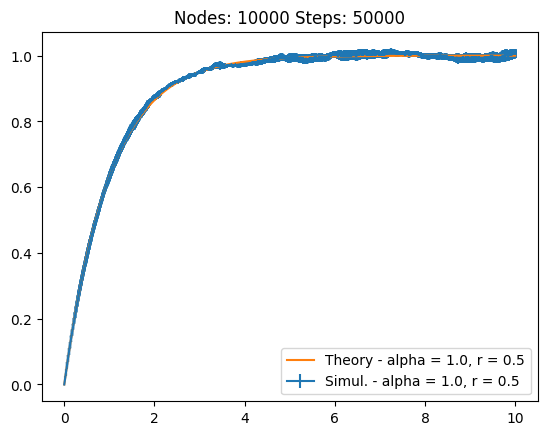

25000 50000 1.0 0.5


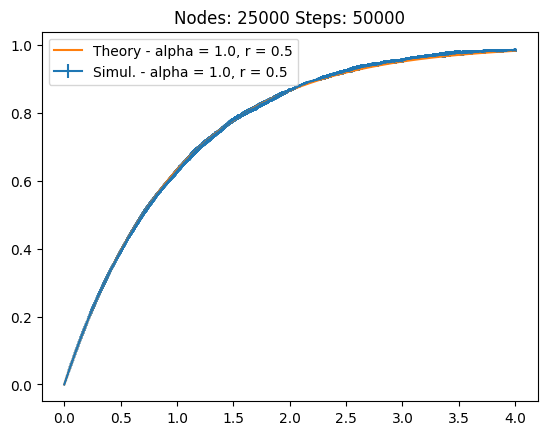

50000 50000 1.0 0.5


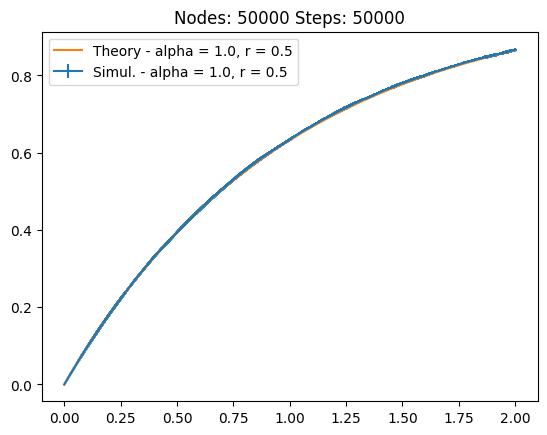

In [6]:
for prefix, file_list in get_simulation_files()[0].items():
    plot_avg_degree(prefix=prefix, file_list=file_list)


In [7]:
def calculate_mean(values: List[List[Dict[int, float]]]):

    num_files = len(values)
    num_steps = len(values[0])
    print(num_steps)

    def process(step_info: Dict[int, float], step: Dict[int, float]) -> None:
         for k, v in step_info.items():
            if not k in step:
                step[k] = float(v)/num_files
            else:
                 step[k] += float(v)/num_files

    series: List[Dict[int, float]] = []

    for i in range(0, num_steps):
            step = {}
            for file_data in values:
                process(file_data[i], step)
            series.append(step)
    
    series_as_dict = {}
    for idx, serie in enumerate(series):
        for key, value in serie.items():
            if not key in series_as_dict:
                series_as_dict[key] = np.zeros(num_steps)
            series_as_dict[key][idx] = value

    return series_as_dict

In [8]:
def plot_degree_distribution(prefix: str, file_list: List[str]) -> None:
    num_nodes, num_steps, alpha, r = process_prefix(prefix)
    print(num_nodes, num_steps, alpha, r)

    def build_dict(row):
        unique, counts = np.unique(row, return_counts=True)
        return dict(zip(unique, counts))

    values = []
    for file in file_list:
        df = pd.read_csv(file, skiprows=1, header=None, delimiter=" ")
        counts = list(map(lambda r: build_dict(r), df.values))
        values.append(counts)

    # I cannot do mean!! I first need to build dictionary, and then do mean over that!

    series = calculate_mean(values)

    min_step: int = 1

    with open(file_list[0]) as f:
        min_step = int(f.readline().strip("\n"))

    pk = pk_builder(alpha=alpha, r=r)

    x_values = np.arange(num_steps) * float(min_step) / float(num_nodes)

    for k, pk_values in series.items():
        if (k < 6):
            plt.yscale("log")
            plt.plot(x_values, pk_values / float(num_nodes), label=str(k) + " - simulation")
            plt.plot(x_values, list(map(lambda x: pk(k, x), x_values)), label=str(k) + " - theory")

    plt.legend()
    plt.title("Nodes: " + str(num_nodes) + " Steps: " + str(num_steps))
    plt.show()


10000 10000 1.0 0.5
10000


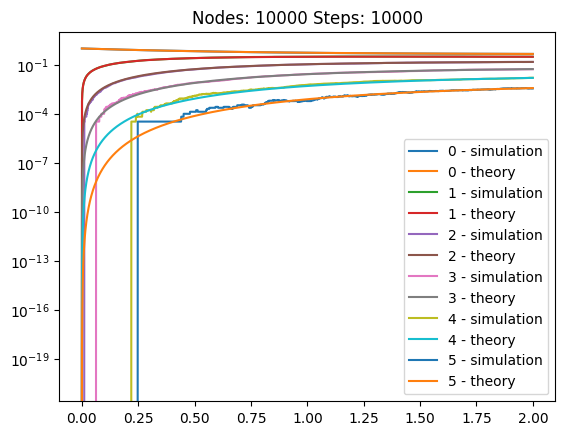

1000 5000 1.0 0.5
5000


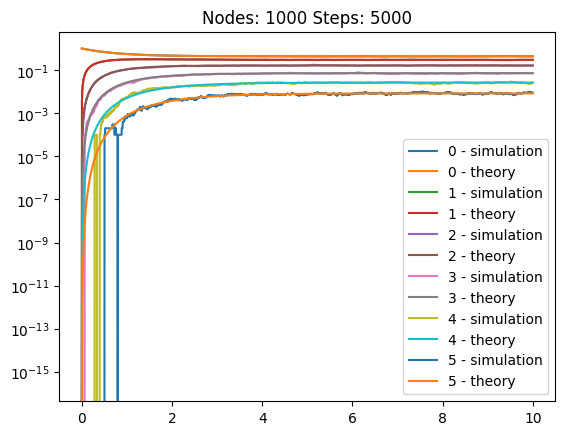

5000 3000 1.0 0.5
3000


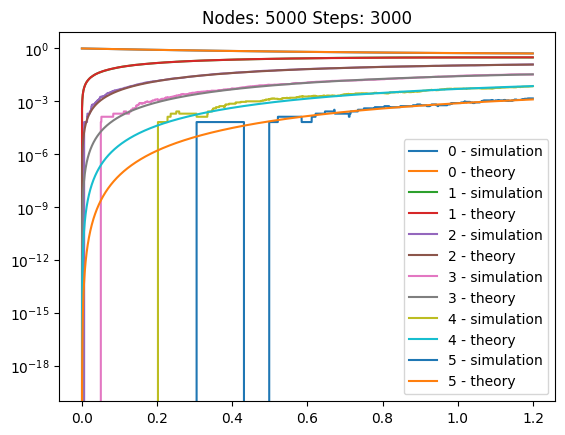

In [12]:
files = get_simulation_files()[1]
for prefix, file_list in files.items():
    plot_degree_distribution(prefix=prefix, file_list=file_list)


In [141]:
def giant_component_builder(
    alpha: float, r: float, num_nodes: int
) -> Callable[[float], float]:
    # We can restrict infinity to (num_nodes - 1) as pk k>= num_nodes - 1 = 0
    print(alpha, r, num_nodes)

    def s(t: float) -> float:
        expected_k = expected_k_builder(alpha=alpha, r=r)
        expected_k_t = expected_k(t)
        pk = pk_builder(alpha=alpha, r=r)
        pk_t = [pk(k, t) for k in range(0, num_nodes)]

        u_t = calculate_u(expected_k_t, pk_t)
        res = 0
        for k in range(1, num_nodes - 1):
            res += pk_t[k] * (1 - u_t**k)

        return res

    # A les condicions inicials, un node si/no pertany al component gegant -> u[0] = 0/1
    # => u[t] = 1/(<k>(t)) * sum(k*pk(t)*u[t]**k-1)
    def calculate_u(expected_k_t: float, pk_t: List[float]) -> float:

        diff = 0.1  # It just needs to be better than the acceptance threshold
        u = 0.5  # Initial value
        while diff > 1e-6:
            sum_u = 0
            sum_du = 0
            for k in range(1, num_nodes):
                sum_u += k * pk_t[k] * (u ** (k - 1))
                sum_du += k * (k - 1) * pk_t[k] * (u ** (k - 2))
            diff = u - sum_u / expected_k_t
            u = u - (u - sum_u / expected_k_t)/(1 - sum_du / expected_k_t)
        return u

    return lambda t: 0 if t < 0.02 else s(t)


In [142]:
def plot_giant_component(prefix: str, file_list: List[str]) -> None:
    num_nodes, num_steps, alpha, r = process_prefix(prefix)
    print(num_nodes, num_steps, alpha, r)

    min_step: int = 1
    values = []
    for file in file_list:
        df = pd.read_csv(file)
        [min_step] = df.keys()
        values.append(df[min_step])

    grouped_files = pd.concat(values).groupby(level=0)
    mean, std = grouped_files.mean().values, grouped_files.std().values
    print("this done")

    # TODO:
    giant_component = giant_component_builder(alpha=alpha, r=r, num_nodes=num_nodes)

    x_values = np.arange(num_steps) * float(min_step) / float(num_nodes)
    x_theory_values = np.arange(num_steps/10) * 10 * float(min_step) / float(num_nodes)
    plt.title("Nodes: " + str(num_nodes) + " Steps: " + str(num_steps))
    plt.errorbar(x_values, mean/float(num_nodes), yerr=std/float(num_nodes))
    print("real_data_plotted")
    plt.plot(x_theory_values, list(map(giant_component, x_theory_values)))
    plt.show()


100 1000 1.0 0.5
this done
1.0 0.5 100
real_data_plotted


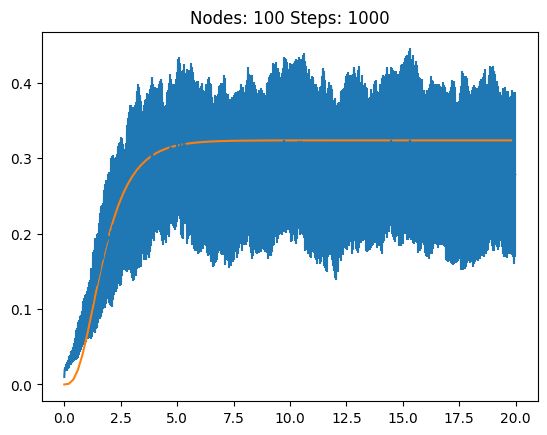

250 300 1.0 0.5
this done
1.0 0.5 250
real_data_plotted


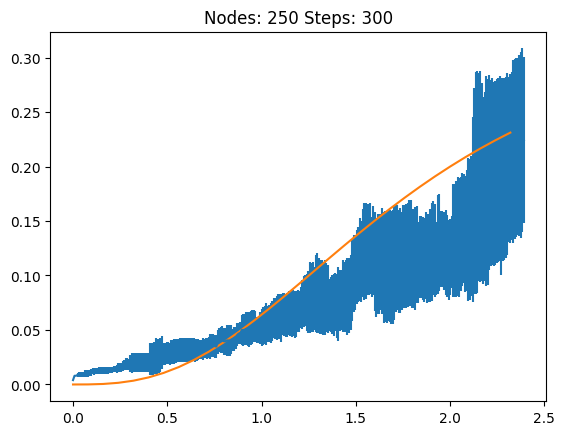

500 2000 1.0 0.5
this done
1.0 0.5 500
real_data_plotted


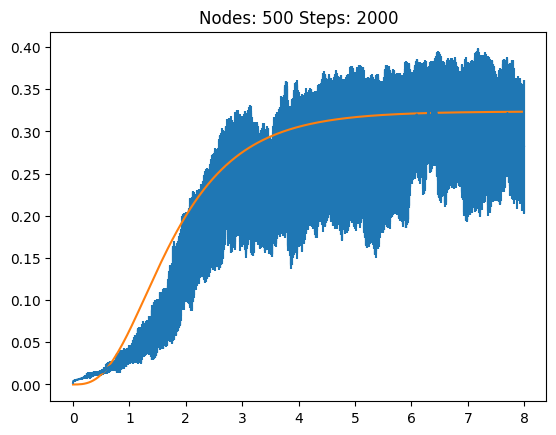

In [143]:
files = get_simulation_files()[2]
for prefix, file_list in files.items():
    plot_giant_component(prefix=prefix, file_list=file_list)
